In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import os

In [3]:
data_dir = "Train_Spectrogram_Images"
img_size = (128, 128)
batch_size = 32
# Data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# === Load Pre-trained NASNetMobile Model ===
base_model = NASNetMobile(input_shape=(img_size[0], img_size[1], 3),
                          include_top=False,
                          weights='imagenet')

# === Freeze base model layers ===
base_model.trainable = False

# === Add custom classification layers ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

# === Final model ===
model = Model(inputs=base_model.input, outputs=output_layer)

# === Compile ===
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Train ===
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator
)


Found 5328 images belonging to 7 classes.
Found 1328 images belonging to 7 classes.
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 13s 1us/step


C:\Users\asus\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 204s 739ms/step - accuracy: 0.7486 - loss: 0.7943 - val_accuracy: 0.8095 - val_loss: 0.5499
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 96s 572ms/step - accuracy: 0.8118 - loss: 0.5520 - val_accuracy: 0.8215 - val_loss: 0.5256
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 98s 585ms/step - accuracy: 0.8125 - loss: 0.5303 - val_accuracy: 0.8125 - val_loss: 0.5397
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 100s 597ms/step - accuracy: 0.8203 - loss: 0.5091 - val_accuracy: 0.8178 - val_loss: 0.5172
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 75s 446ms/step - accuracy: 0.8312 - loss: 0.4954 - val_accuracy: 0.8155 - val_loss: 0.5188
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 100s 596ms/step - accuracy: 0.8305 - loss: 0.4781 - val_accuracy: 0.8276 - val_loss: 0.5209
Epoch 7/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 101s 604ms/step - accuracy: 0.8350 - loss: 0.4823 - val_accuracy: 0.8185 - val_loss: 0.5370
Epoch 8/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 95s 570ms/step - accuracy: 0.82

In [5]:
model.save("Spectrogram_Images_NASNetMobile_model_100epoch.h5")

Found 2450 images belonging to 7 classes.


C:\Users\asus\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step
Classification Report:
                precision    recall  f1-score   support

Coarse Crackel       0.33      0.06      0.10        34
  Fine Crackle       0.41      0.36      0.38       255
        Normal       0.82      0.91      0.86      1728
       Rhonchi       0.67      0.29      0.40        14
       Stridor       0.00      0.00      0.00         2
        Wheeze       0.66      0.47      0.55       413
Wheeze+Crackle       0.00      0.00      0.00         4

      accuracy                           0.76      2450
     macro avg       0.41      0.30      0.33      2450
  weighted avg       0.74      0.76      0.74      2450



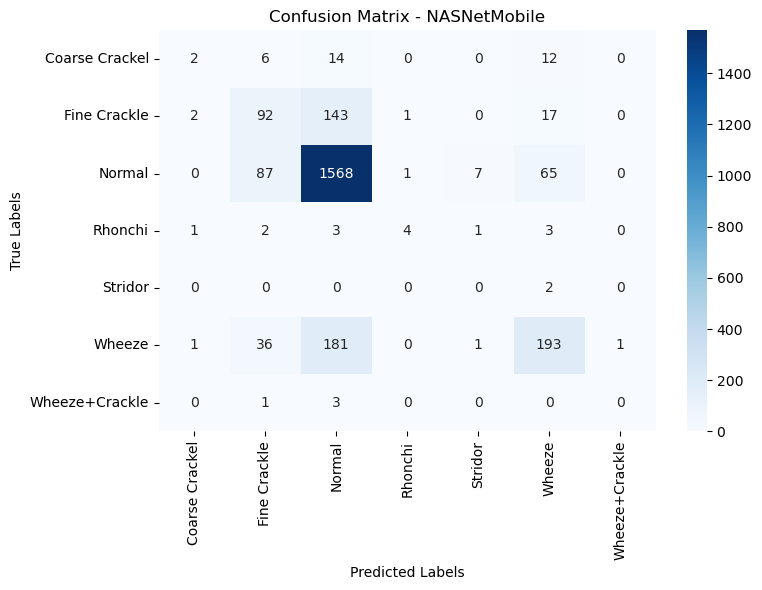

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# === Path to your test spectrogram image dataset ===
test_dir = "Test_Spectrogram_images"

# === Image preprocessing (same as NASNetMobile training) ===
img_size = (128, 128)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure predictions align with true labels
)

# === Load NASNetMobile model ===
model = tf.keras.models.load_model("Spectrogram_Images_NASNetMobile_model_100epoch.h5")

# === Predict ===
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# === Classification Report ===
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix - NASNetMobile')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

In [11]:
cm = confusion_matrix(y_true, y_pred)

In [13]:
cm

array([[   2,    6,   14,    0,    0,   12,    0],
       [   2,   92,  143,    1,    0,   17,    0],
       [   0,   87, 1568,    1,    7,   65,    0],
       [   1,    2,    3,    4,    1,    3,    0],
       [   0,    0,    0,    0,    0,    2,    0],
       [   1,   36,  181,    0,    1,  193,    1],
       [   0,    1,    3,    0,    0,    0,    0]], dtype=int64)

In [15]:
diagonal = np.diag(cm)
print(diagonal)
sum(diagonal)

[   2   92 1568    4    0  193    0]


1859

In [17]:
SE = (sum(np.diag(cm)) - cm[2][2]) / (sum(sum(cm)) - sum(cm[2]))

In [19]:
SE

0.40304709141274236

In [21]:
SP = cm[2][2] / sum(cm[2])

In [23]:
SP

0.9074074074074074

In [25]:
print('AS = ',(SE+SP)/2)

AS =  0.6552272494100749


In [27]:
print('HS = ',(2*SE*SP)/(SE+SP))

HS =  0.5581695764503248


In [29]:
print('Score = ',(((SE+SP)/2)+((2*SE*SP)/(SE+SP)))/2)

Score =  0.6066984129301999
